In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

[CKLS Process:](https://en.wikipedia.org/wiki/Chan%E2%80%93Karolyi%E2%80%93Longstaff%E2%80%93Sanders_process)

$ dY_t = \theta (\mu - Y_t) dt + \sigma Y_{t}^p dW_t $

$ Y_{t + \Delta t} - Y_t = \theta (\mu - Y_t) \Delta t + \sigma Y_{t}^p (W_{t+\Delta t} - W_t) $

$ Y_{t + \Delta t} - Y_t = \theta (\mu - Y_t) \Delta t + \sigma Y_{t}^p \epsilon_t \quad \epsilon_t \sim \mathcal{N}(0, \Delta t)$

$ Y_{t + \Delta t} = Y_t + \theta (\mu - Y_t) \Delta t + \sigma Y_{t}^p \epsilon_t \quad \epsilon_t \sim \mathcal{N}(0, \Delta t)$

Letting $\Delta t = 1$:

$ Y_{t+1} = Y_t + \theta (\mu - Y_t) + \sigma Y_{t}^p \epsilon_t \quad \epsilon_t \sim \mathcal{N}(0, 1)$

---

Let $X_t = \ln(Y_t)$

Then, by Ito's Lemma:

$ dX_t = (\theta (\frac{\mu}{Y_t} - 1) - \frac{\sigma^2}{2} Y_{t}^{2p-2}) dt + \sigma Y_{t}^{p-1} dW_t $

$ dX_t = (\theta (\frac{\mu}{\exp(X_t)} - 1) - \frac{\sigma^2}{2} \exp(X_t)^{2p-2}) dt + \sigma \exp(X_t)^{p-1} dW_t $ because $ Y_t = \exp(X_t) $

$ X_{t+\Delta t} = X_t + (\theta (\frac{\mu}{\exp(X_t)} - 1) - \frac{\sigma^2}{2} \exp(X_t)^{2p-2}) \Delta t + \sigma \exp(X_t)^{p-1} \epsilon_t \quad \epsilon_t \sim \mathcal{N}(0, \Delta t) $

In [463]:
rng = np.random.default_rng()

theta = 0.05
mu = 25
sigma = 0.5
p = 0.5
Y_0 = 25
n = 10000
dt = 0.01

ts = [0]
Y = [Y_0]
randn = rng.standard_normal(n)
for t in range(n - 1):
    epsilon = np.sqrt(dt) * randn[t]
    ts.append(ts[t] + dt)
    Y.append(Y[t] + theta * (mu - Y[t]) * dt + sigma * Y[t] ** p * epsilon)

In [464]:
ts = [0]
X = [np.log(Y_0)]
for t in range(n - 1):
    epsilon = np.sqrt(dt) * randn[t]
    ts.append(ts[t] + dt)
    X.append(
        X[t]
        + (
            theta * ((mu / np.exp(X[t])) - 1)
            - (sigma**2 / 2) * np.exp(X[t]) ** (2 * p - 2)
        )
        * dt
        + sigma * np.exp(X[t]) ** (p - 1) * epsilon
    )

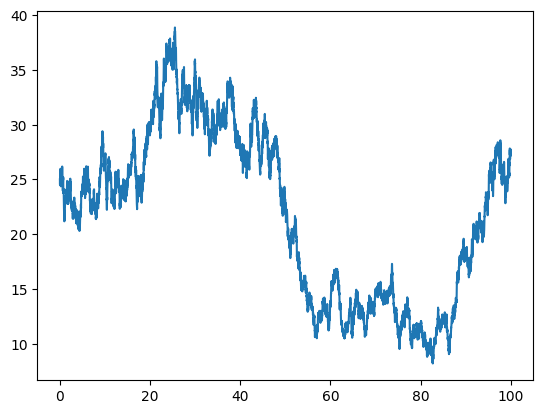

In [466]:
plt.plot(ts, Y)

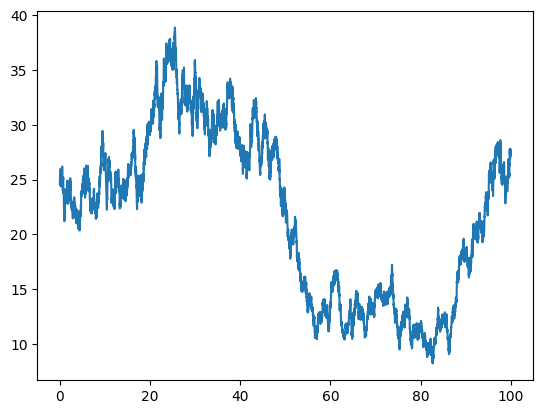

In [467]:
plt.plot(ts, np.exp(X))

In [500]:
# log prob and random generator for Y_t
def logp(value, theta, mu, sigma, p, y_0):
    logp = 0
    for t in range(1, len(value)):
        mu_t = value[t - 1] + theta * (mu - value[t - 1])
        sigma_t = sigma * value[t - 1] ** p
        logp += pm.distributions.dist_math.log_normal(
            value[t], mean=mu_t, sigma=sigma_t
        )
    return logp


def random(theta, mu, sigma, p, y_0, rng=None, size=None):
    steps = size[0]
    if size is None:
        return None
    else:
        y = np.full(size, y_0, dtype=float)

    for t in range(1, steps):
        y[t] = (
            y[t - 1]
            + theta * (mu - y[t - 1])
            + sigma * y[t - 1] ** p * rng.standard_normal()
        )

    return y

In [732]:
# log prob and random generator for X_t
def logp(value, theta, mu, sigma, p, y_0):
    logp = 0
    for t in range(1, value.size.type()):
        mu_t = value[t - 1] + (
            theta * ((mu / np.exp(value[t - 1])) - 1)
            - (sigma**2 / 2) * np.exp(value[t - 1]) ** (2 * p - 2)
        )
        sigma_t = igma * np.exp(value[t - 1]) ** (p - 1)
        logp += pm.distributions.dist_math.log_normal(
            value[t], mean=mu_t, sigma=sigma_t
        )
    return logp


def random(theta, mu, sigma, p, y_0, rng=None, size=None):
    steps = size[0]
    if size is None:
        return None
    else:
        y = np.full(size, np.log(y_0), dtype=float)

    for t in range(1, steps):
        y[t] = (
            y[t - 1]
            + (
                theta * ((mu / np.exp(y[t - 1])) - 1)
                - (sigma**2 / 2) * np.exp(y[t - 1]) ** (2 * p - 2)
            )
            + sigma * np.exp(y[t - 1]) ** (p - 1) * rng.standard_normal()
        )

    return y

In [733]:
with pm.Model() as m:
    theta = pm.Uniform("theta", 0, 1)
    mu = pm.Gamma("mu", alpha=10, beta=0.5)
    sigma = pm.Gamma("sigma", alpha=0.5, beta=15)
    p = pm.Gamma("p", alpha=5, beta=8)
    y_0 = pm.Gamma("y_0", alpha=10, beta=0.5)
    pm.CustomDist(
        "CKLS", theta, mu, sigma, p, y_0, logp=logp, random=random, observed=data
    )

    idata = pm.sample()

TypeError: 'TensorVariable' object cannot be interpreted as an integer